# Лабораторная работа #1: Рекуррентные нейронные сети

## Задача 1: PoS-tagging

В данной лабораторной работе будут использоваться корпуса проекта Universal Dependencies: http://universaldependencies.org/

- Ukranian - https://github.com/UniversalDependencies/UD_Ukrainian-IU/tree/master
- Galician - https://github.com/UniversalDependencies/UD_Galician-CTG/tree/master

ГАЛЛЬСКИЙ ЯЗЫК

Категория - Языки Евразии;
Индоевропейская семья;
Кельтская ветвь.

Письменность - италийские алфавиты, греческий алфавит, латиница

Это мёртвый кельтский язык, широко распространённый в Галлии в доримский период , до того, когда был окончательно вытеснен народной латынью. Согласно одной из двух основных классификаций кельтских языков, галльский и ряд других мёртвых языков — кельтиберский и лепонтийский — объединяют в так называемые «континентальные кельтские языки». Другая классификация, делящая кельтские языки на Q-кельтские и P-кельтские, относит галльский ко второй ветви.

### Часть I Работа с корпусом CoNLL
Предварительная обработка, чтение и парсинг корпуса, а также определение размера словаря.
Необходимо получить следущие статистики:

* Число предложений / уникальных словоформ;
* Число уникальных PoS-тегов;
* Максимальное и минимальное число слов в предложении;
* Математическое ожидание и медиана числа слов в предложении;
* Доля новых (не встречавшихся в тренировочной выборке) слов в тестовой выборке

In [1]:
%matplotlib inline
from conllu import parse, parse_tree
from collections import Counter
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, RepeatVector, Embedding, GRU, LSTM, SimpleRNN, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import top_k_categorical_accuracy

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

**Имена файлов с тренировочным и тестовым наборами:**

In [2]:
train_conll_fname = 'gl_ctg-ud-train.conllu'
test_conll_fname = 'gl_ctg-ud-test.conllu'       

Функция 
    parsed_sentences
читает conll файл, и проводит его обработку, подсчитывая:
* sents_word - список списков словоформ (внешний список - предложения, внутренний список - слова в этом предложении);
* word_frequencies - коллекция типа Counter для подсчета частоты словоформ
* sents_pos - список списов PoS тегов (соответствующих словам из sents_word);
* pos_frequencies - коллекция типа Counter для подсчета частоты PoS-тегов.

In [3]:
def parsed_sentences(conll_fname):
    conll_file = open(conll_fname, 'r', encoding='utf-8')
    conll_data = conll_file.read()
    conll_file.close()
    
    sents_word = []
    word_frequencies = Counter()
    
    sents_pos = []
    pos_frequencies = Counter()

    for current_parsed_sentence in parse(conll_data):
        current_sentence_words = []
        current_sentence_pos = []        
        for separated_parsed_words in current_parsed_sentence:
            current_sentence_words.append(separated_parsed_words['form'])
            word_frequencies[separated_parsed_words['form']] += 1
            current_sentence_pos.append(separated_parsed_words['upostag'])
            pos_frequencies[separated_parsed_words['upostag']] += 1
        
        sents_word.append(current_sentence_words)
        sents_pos.append(current_sentence_pos)

    return (sents_word, word_frequencies,
           sents_pos, pos_frequencies)


Считываем файлы тренировочной и тестовой выборки, и формируем (для каждого свою) наборы 
* sents_word
* word_frequencies
* sents_pos
* pos_frequencies

In [4]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

Выведете статистику, для тренировочной и тестовой выборки
Статистика должна отражать:
* Число предложений;
* Число словоформ;
* Число уникальных PoS тегов;
* Максимальное число слов в предложении;
* Минимальное число слов в предложении;
* Среднее арифметическое и среднее медианное число слов в предложении;
* Доля уникальных слов в тестовой выборке;

In [5]:
print("Stats: ")

train_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in sents_word])
test_length_of_sentences_list = np.array([len(current_sentence) for current_sentence in test_sents_word])

print("Train set: \n\tCount sentences: {} \n\tUnique words: {}".format(len(sents_word), len(word_frequencies)))
print("\tUnique PoS tags: {}".format(len(pos_frequencies)))
print("\tMax count words in sentences: {}".format(np.max(train_length_of_sentences_list)))
print("\tMin count words in sentence: {}".format(np.min(train_length_of_sentences_list)))
print("\tMiddle count words in sentence: {}".format(np.mean(train_length_of_sentences_list)))
print("\tMedian count words in sentence: {}".format(np.median(train_length_of_sentences_list)))
print("\tPercent of unique PoS tags in test: {}".format(100 - len(set(train_length_of_sentences_list)&set(test_length_of_sentences_list))/ 
len(set(train_length_of_sentences_list))*100))

Stats: 
Train set: 
	Count sentences: 2272 
	Unique words: 13236
	Unique PoS tags: 17
	Max count words in sentences: 91
	Min count words in sentence: 3
	Middle count words in sentence: 38.149647887323944
	Median count words in sentence: 37.0
	Percent of unique PoS tags in test: 16.949152542372886


На основании полученных статистик, задаем параметры для нейронных сетей:
* Максимальная длина последовательности (MAX_SEQLEN);
* Максимальное количество атрибутов (S_MAX_FEATURES);
* Максимальное количество тегов (T_MAX_FEATURES);

**Замечание**: *MAX_SEQLEN* не обязательно должна равна максимальному числу слов в предложении, особенно если встречается всего 1 такое предложение.

In [6]:
MAX_SEQLEN = 38
S_MAX_FEATURES = 13236
T_MAX_FEATURES = 17

Объясните свой выбор целевых параметров:
* MAX_SEQLEN - выбрано среднее значение числа слов в предложении  
* S_MAX_FEATURES - выбрано количество уникальных слов во всем тексте, для максмального
* T_MAX_FEATURES 

Задаем параметры для числа нейронов в скрытом слое, объема пространства погружения и размера пакета.

In [37]:
EMBED_SIZE = 100
HIDDEN_SIZE = 200

BATCH_SIZE = 64

Задаем число эпох и итераций:

In [38]:
NUM_EPOCHS = 5
NUM_ITERATIONS = 10

Как и в большинстве других задач глубокого обучения, каждая строчка должна быть закодирована индексами слов. Кроме того, выход (PoS-теги) должны быть последовательностями индексов PoS-тегов.
Поэтомк, мы создаем табличцы для перевода слов/PoS-тегов в соответствующие индексы.
Словарь словоформ должен иметь 2 дополнительных метки:
* PAD - для заполнения (характеризует пустоту), когда размер предложения меньше, чем MAX_SEQLEN
* UNK - для неизвестных словоформ.

Кроме того, захотим проиллюстрировать PoS-теггер, поэтому нужно составить таблицы для поиска словоформ и частеречевых тегов.
Ниже показано задание таблиц.

Составляем таблицу поиска для словоформ:

In [39]:
s_vocabsize = min(len(word_frequencies), S_MAX_FEATURES) + 2
s_word2index = {x[0]:i+2 for i, x in 
    enumerate(word_frequencies.most_common(S_MAX_FEATURES))}
s_word2index["PAD"] = 0 # Для заполнения, когда размер предлложения меньше, чем MAX_SEQ
s_word2index["UNK"] = 1 # Для неизвестных словоформ, которые могут встретиться
s_index2word = {v:k for k, v in s_word2index.items()}

**Замечание: ** для PoS-тегов элемент UNK не нужен, поскольку список частей речи уже известен. Элемент PAD нужен.

In [40]:
t_vocabsize = min(len(pos_frequencies), T_MAX_FEATURES) + 1
t_word2index = {x[0]:i+1 for i, x in 
    enumerate(pos_frequencies.most_common(T_MAX_FEATURES))}

t_word2index["PAD"] = 0
t_index2word = {v:k for k, v in t_word2index.items()}

### Описание задания и работы используемых нейронных сетей

Составляем целевую нейронную сеть, которая и будет выполнять частеречную разметку.

Коротко об архитектуре нейронной сети:
Как и в других задачах, считаем, что входом в нейросеть является трехмерный тензор, элементами которого являются индексы слов, длины MAX_SEQLEN;

Это проходит через слой погружения (Embedding), которому явно указывается размер словаря и размерность погружения, поэтому результат прохождения входного тензора через слой погружения будет тензор сл. формата:
(None, MAX_SEQLEN, EMBED_SIZE);

Далее этот тензор передается encoder'у - представляющий собой слой рекуррентной нейронной сети с размером выхода HIDDEN_SIZE. LSTM настроен на возврат единственного контекстного вектора (return_sequences=False - по умолчанию) после обработки последовательности длины MAX_SEQLEN, поэтому тензор LSTM слоя имеет форму (None, HIDDEN_SIZE).

Этот контекстный вектор далее реплицируется слоем 
    RepeatVector
в тензор формы (None, MAX_SEQLEN, t_vocab_size). В качестве функции активации в плотном слое используется softmax.


**Рассмотрим 4 архитектуры для нейронных сетей**:
* LSTM
* Bidirectional LSTM
* GRU
* SimpleRNN

*Дополнительная функция для визуализации результатов:*

In [41]:
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=3, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=3, label='validation')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=3, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=3, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

В качестве потерь мы используем категориальную энтропию, т.к. решаем задачу Multi-Class Classification
    

### LSTM Architecture

In [42]:
def build_pos_tagger_LSTM():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(LSTM(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(LSTM(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

LSTM_POS_TAGGER = build_pos_tagger_LSTM()
LSTM_POS_TAGGER.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 38, 100)           1323800   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               240800    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 38, 200)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 38, 200)           320800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 38, 18)            3618      
_________________________________________________________________
activation_5 (Activation)    (None, 38, 18)            0         
Total params: 1,889,018
Trainable params: 1,889,018
Non-trainable params: 0
_________________________________________________________________


### Biderectional LSTM Architecture

In [43]:
def build_pos_tagger_Bidirectional():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(Bidirectional(LSTM(HIDDEN_SIZE))) 
    model.add(RepeatVector(MAX_SEQLEN)) 
    model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))) 
    model.add(TimeDistributed(Dense(t_vocabsize))) 
    model.add(Activation("softmax")) 
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

Bidirectional_POS_TAGGER = build_pos_tagger_Bidirectional()
Bidirectional_POS_TAGGER.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 38, 100)           1323800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               481600    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 38, 400)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 38, 400)           961600    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 38, 18)            7218      
_________________________________________________________________
activation_6 (Activation)    (None, 38, 18)            0         
Total params: 2,774,218
Trainable params: 2,774,218
Non-trainable params: 0
_________________________________________________________________


### GRU Architecture

In [44]:
def build_pos_tagger_GRU():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(GRU(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(GRU(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

GRU_POS_TAGGER = build_pos_tagger_GRU()
GRU_POS_TAGGER.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 38, 100)           1323800   
_________________________________________________________________
gru_4 (GRU)                  (None, 200)               180600    
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 38, 200)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 38, 200)           240600    
_________________________________________________________________
time_distributed_7 (TimeDist (None, 38, 18)            3618      
_________________________________________________________________
activation_7 (Activation)    (None, 38, 18)            0         
Total params: 1,748,618
Trainable params: 1,748,618
Non-trainable params: 0
_________________________________________________________________


### SimpleRNN Architecture

In [45]:
def build_pos_tagger_SimpleRNN():
    model = Sequential()
    model.add(Embedding(s_vocabsize, EMBED_SIZE,
                    input_length=MAX_SEQLEN,
                    embeddings_initializer="glorot_uniform"))
    
    model.add(SimpleRNN(HIDDEN_SIZE))
    model.add(RepeatVector(MAX_SEQLEN))
    
    model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=True))
    model.add(TimeDistributed(Dense(t_vocabsize)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
    return model

SimpleRNN_POS_TAGGER = build_pos_tagger_SimpleRNN()
SimpleRNN_POS_TAGGER.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 38, 100)           1323800   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200)               60200     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 38, 200)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 38, 200)           80200     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 38, 18)            3618      
_________________________________________________________________
activation_8 (Activation)    (None, 38, 18)            0         
Total params: 1,467,818
Trainable params: 1,467,818
Non-trainable params: 0
_________________________________________________________________


## Обучаем модели и посчитываем статистики

Подсчитаем объем количества батчей для тренировочной и тестовой выборки, кроме того, сделаем функцию для получения генератора батчей.

In [46]:
num_train_samples = len(sents_word) // BATCH_SIZE
num_test_samples = len(test_sents_word) // BATCH_SIZE

print("\tV of train samples: {}".format(num_train_samples))
print("\tV of test samples: {}".format(num_test_samples))

def get_or_else(dictionary, key, default_value):
    try:
        return dictionary[key]
    except KeyError:
        return default_value

def generate_batch(
    s_sents,  # sentences_train
    s_word2index, # word to index dictionary
    t_sents, # 
    t_word2index, 
    batch_size, 
    maxlen
):
    while True:
        # shuffle the input
        indices = np.random.permutation(np.arange(len(s_sents)))
        ss_sents = [s_sents[ix] for ix in indices]
        ts_sents = [t_sents[ix] for ix in indices]
        # convert to word indices
        si_sents = [[get_or_else(s_word2index, word, s_word2index["UNK"]) 
                    for word in sent] 
                    for sent in ss_sents]
        ti_sents = [[t_word2index[word] for word in sent]
                    for sent in ts_sents]
        # inner loop should run for an epoch
        num_batches = len(s_sents) // batch_size
        for i in range(num_batches):
            s_batch = si_sents[i * batch_size : (i + 1) * batch_size]
            t_batch = ti_sents[i * batch_size : (i + 1) * batch_size]
            sp_batch = sequence.pad_sequences(s_batch, maxlen=maxlen)
            tp_batch = sequence.pad_sequences(t_batch, maxlen=maxlen)
            tpc_batch = utils.to_categorical(tp_batch.reshape(-1, 1), 
                num_classes=len(t_word2index)).reshape(batch_size, 
                -1, len(t_word2index))
            yield sp_batch, tpc_batch

	V of train samples: 35
	V of test samples: 13


## 1. LSTM

Инициализируем генераторы для тренировочной и тестовой выборки. 

In [47]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

Обновляем списки с историями для точности, функции потерь на тренировочной и тестовой выборках:

In [48]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []


In [49]:
for i in range(NUM_ITERATIONS):    
    history = LSTM_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = LSTM_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
35/35 [==============================] - 14s 401ms/step - loss: 2.4723 - acc: 0.2032 - val_loss: 2.3071 - val_acc: 0.2422
Epoch 2/5
35/35 [==============================] - 8s 242ms/step - loss: 2.2543 - acc: 0.2505 - val_loss: 2.1521 - val_acc: 0.2748
Epoch 3/5
35/35 [==============================] - 9s 257ms/step - loss: 2.1693 - acc: 0.2670 - val_loss: 2.1398 - val_acc: 0.2819
Epoch 4/5
35/35 [==============================] - 9s 247ms/step - loss: 2.1370 - acc: 0.2744 - val_loss: 2.1118 - val_acc: 0.2882
Epoch 5/5
35/35 [==============================] - 9s 245ms/step - loss: 2.1213 - acc: 0.2777 - val_loss: 2.0857 - val_acc: 0.2930
Iteration # 1
--------------------------------------------------------------------------------
label:     o//DET UNK//NOUN non//PART técnico//ADJ UNK//_ incluirán//VERB se//PRON todas//DET as//DET indicacións//NOUN do//_ de//ADP o//DET proxecto//NOUN básico//ADJ ,//PUNCT así//ADV como//SCONJ do//_ de//ADP o//DET resto//NOUN dos//_ de//ADP os/

35/35 [==============================] - 9s 264ms/step - loss: 2.0384 - acc: 0.2902 - val_loss: 2.0194 - val_acc: 0.3115
Epoch 2/5
35/35 [==============================] - 9s 258ms/step - loss: 2.0166 - acc: 0.2985 - val_loss: 1.9980 - val_acc: 0.3158
Epoch 3/5
35/35 [==============================] - 9s 247ms/step - loss: 2.0075 - acc: 0.2986 - val_loss: 2.0091 - val_acc: 0.3051
Epoch 4/5
35/35 [==============================] - 8s 241ms/step - loss: 1.9939 - acc: 0.3014 - val_loss: 2.0091 - val_acc: 0.3110
Epoch 5/5
35/35 [==============================] - 8s 240ms/step - loss: 1.9950 - acc: 0.2992 - val_loss: 2.0046 - val_acc: 0.3032
Iteration # 3
--------------------------------------------------------------------------------
label:     o//DET noso//DET equipo//NOUN de//ADP investigación//NOUN se//PRON dedica//VERB precisamente//ADV á//_ a//ADP a//DET tarefa//NOUN da//_ de//ADP a//DET construción//NOUN ,//PUNCT UNK//NOUN e//CCONJ difusión//NOUN do//_ de//ADP o//DET coñecemento//NOU

35/35 [==============================] - 8s 241ms/step - loss: 1.9352 - acc: 0.3119 - val_loss: 1.9368 - val_acc: 0.3182
Epoch 2/5
35/35 [==============================] - 9s 247ms/step - loss: 1.9511 - acc: 0.3048 - val_loss: 1.9509 - val_acc: 0.3146
Epoch 3/5
35/35 [==============================] - 8s 241ms/step - loss: 1.9381 - acc: 0.3066 - val_loss: 1.9773 - val_acc: 0.3126
Epoch 4/5
35/35 [==============================] - 8s 241ms/step - loss: 1.9174 - acc: 0.3135 - val_loss: 1.9490 - val_acc: 0.3139
Epoch 5/5
35/35 [==============================] - 8s 240ms/step - loss: 1.9139 - acc: 0.3121 - val_loss: 1.9372 - val_acc: 0.3245
Iteration # 5
--------------------------------------------------------------------------------
label:     As//DET emisións//NOUN de//ADP CH4//NUM UNK//_ obteñen//VERB se//PRON a//ADP partir//VERB dos//_ de//ADP os//DET valores//NOUN de//ADP emisións//NOUN de//ADP COV//PROPN ,//PUNCT tomando//VERB o//DET valor//NOUN UNK//VERB para//ADP o//DET Inventario/

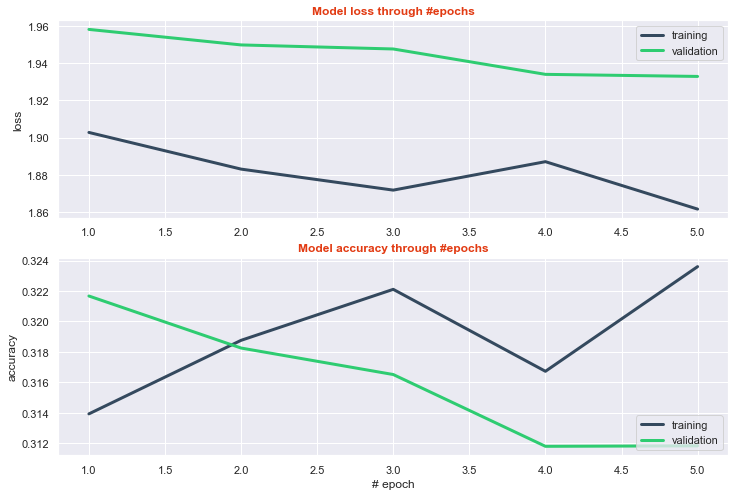

In [50]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## 2. Biderectional LSTM

In [21]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [22]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

In [23]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [24]:
for i in range(NUM_ITERATIONS):    
    history = Bidirectional_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = Bidirectional_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
35/35 [==============================] - 19s 548ms/step - loss: 2.3902 - acc: 0.2352 - val_loss: 2.1010 - val_acc: 0.3055
Epoch 2/5
35/35 [==============================] - 10s 293ms/step - loss: 2.0855 - acc: 0.3004 - val_loss: 2.0038 - val_acc: 0.3262
Epoch 3/5
35/35 [==============================] - 10s 292ms/step - loss: 2.0333 - acc: 0.3067 - val_loss: 1.9803 - val_acc: 0.3268
Epoch 4/5
35/35 [==============================] - 10s 299ms/step - loss: 2.0028 - acc: 0.3099 - val_loss: 1.9772 - val_acc: 0.3265
Epoch 5/5
35/35 [==============================] - 10s 297ms/step - loss: 1.9761 - acc: 0.3137 - val_loss: 1.9380 - val_acc: 0.3334
Iteration # 1
--------------------------------------------------------------------------------
label:     os//DET feitos//NOUN UNK//ADJ polos//_ por//ADP os//DET UNK//NOUN da//_ de//ADP a//DET Comisión//NOUN Europea//ADJ coma//SCONJ as//DET deficiencias//NOUN dos//_ de//ADP os//DET sistemas//NOUN de//ADP control//NOUN e//CCONJ vixilancia/

35/35 [==============================] - 11s 311ms/step - loss: 1.8514 - acc: 0.3359 - val_loss: 1.8633 - val_acc: 0.3437
Epoch 2/5
35/35 [==============================] - 10s 285ms/step - loss: 1.8073 - acc: 0.3501 - val_loss: 1.8414 - val_acc: 0.3517
Epoch 3/5
35/35 [==============================] - 10s 285ms/step - loss: 1.7932 - acc: 0.3542 - val_loss: 1.8442 - val_acc: 0.3474
Epoch 4/5
35/35 [==============================] - 10s 285ms/step - loss: 1.7670 - acc: 0.3609 - val_loss: 1.8349 - val_acc: 0.3502
Epoch 5/5
35/35 [==============================] - 10s 284ms/step - loss: 1.7381 - acc: 0.3693 - val_loss: 1.8281 - val_acc: 0.3489
Iteration # 3
--------------------------------------------------------------------------------
label:     a//DET pensión//NOUN non//PART UNK//ADJ ,//PUNCT e//CCONJ que//PRON se//PRON UNK//_ lle//PRON as//PRON UNK//VERB segundo//ADP a//DET evolución//NOUN do//_ de//ADP o//DET UNK//PROPN ,//PUNCT á//_ a//ADP a//DET hora//NOUN de//ADP UNK//_ fixar//VE

35/35 [==============================] - 10s 291ms/step - loss: 1.6178 - acc: 0.4043 - val_loss: 1.8067 - val_acc: 0.3675
Epoch 2/5
35/35 [==============================] - 10s 288ms/step - loss: 1.5922 - acc: 0.4132 - val_loss: 1.8251 - val_acc: 0.3574
Epoch 3/5
35/35 [==============================] - 10s 284ms/step - loss: 1.5740 - acc: 0.4180 - val_loss: 1.8468 - val_acc: 0.3544
Epoch 4/5
35/35 [==============================] - 10s 284ms/step - loss: 1.5565 - acc: 0.4233 - val_loss: 1.8520 - val_acc: 0.3588
Epoch 5/5
35/35 [==============================] - 10s 284ms/step - loss: 1.5432 - acc: 0.4309 - val_loss: 1.8660 - val_acc: 0.3502
Iteration # 5
--------------------------------------------------------------------------------
label:     diferentes//ADJ UNK//NOUN da//_ de//ADP a//DET UNK//PROPN ,//PUNCT e//CCONJ dicir//VERB ,//PUNCT ao//_ a//ADP o//DET finalizar//VERB o//DET embarazo//NOUN ,//PUNCT con//ADP UNK//NOUN ao//_ a//ADP o//DET parto//NOUN ,//PUNCT e//CCONJ cando//PRON

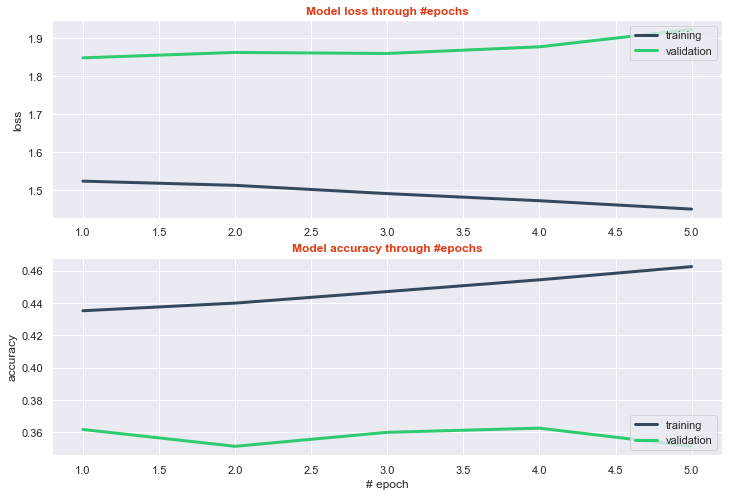

In [25]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## 3. GRU

In [26]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [27]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

In [28]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [29]:
GRU_POS_TAGGER = build_pos_tagger_GRU()

In [30]:
for i in range(NUM_ITERATIONS):    
    history = GRU_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = GRU_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
35/35 [==============================] - 10s 294ms/step - loss: 2.5450 - acc: 0.1841 - val_loss: 2.3718 - val_acc: 0.2190
Epoch 2/5
35/35 [==============================] - 6s 175ms/step - loss: 2.3191 - acc: 0.2348 - val_loss: 2.2798 - val_acc: 0.2433
Epoch 3/5
35/35 [==============================] - 7s 190ms/step - loss: 2.2225 - acc: 0.2574 - val_loss: 2.1876 - val_acc: 0.2718
Epoch 4/5
35/35 [==============================] - 6s 178ms/step - loss: 2.1415 - acc: 0.2761 - val_loss: 2.0967 - val_acc: 0.2945
Epoch 5/5
35/35 [==============================] - 6s 170ms/step - loss: 2.0989 - acc: 0.2837 - val_loss: 2.0522 - val_acc: 0.3054
Iteration # 1
--------------------------------------------------------------------------------
label:     UNK//_ UNK//VERB a//DET adaptación//NOUN da//_ de//ADP a//DET Política//NOUN de//ADP productos//NOUN integrada//VERB proposta//NOUN pola//_ por//ADP a//DET Comisión//NOUN á//_ a//ADP a//DET realidade//NOUN galega//ADJ mediante//ADP a//DET

35/35 [==============================] - 6s 175ms/step - loss: 2.0065 - acc: 0.2950 - val_loss: 2.0155 - val_acc: 0.3047
Epoch 2/5
35/35 [==============================] - 6s 164ms/step - loss: 2.0121 - acc: 0.2935 - val_loss: 2.0327 - val_acc: 0.3010
Epoch 3/5
35/35 [==============================] - 6s 159ms/step - loss: 1.9999 - acc: 0.2969 - val_loss: 1.9913 - val_acc: 0.3123
Epoch 4/5
35/35 [==============================] - 6s 162ms/step - loss: 1.9917 - acc: 0.2978 - val_loss: 2.0052 - val_acc: 0.3101
Epoch 5/5
35/35 [==============================] - 5s 155ms/step - loss: 1.9825 - acc: 0.3003 - val_loss: 2.0152 - val_acc: 0.3005
Iteration # 3
--------------------------------------------------------------------------------
label:     lei//NOUN mantén//VERB os//DET criterios//NOUN xerais//ADJ para//ADP a//DET atribución//NOUN da//_ de//ADP a//DET competencia//NOUN territorial//ADJ ,//PUNCT sen//ADP UNK//VERB UNK//ADV os//DET UNK//NOUN especiais//ADJ por//ADP razón//NOUN da//_ de/

35/35 [==============================] - 6s 166ms/step - loss: 1.9295 - acc: 0.3093 - val_loss: 1.9895 - val_acc: 0.3106
Epoch 2/5
35/35 [==============================] - 6s 172ms/step - loss: 1.9234 - acc: 0.3101 - val_loss: 1.9932 - val_acc: 0.3107
Epoch 3/5
35/35 [==============================] - 6s 160ms/step - loss: 1.9117 - acc: 0.3127 - val_loss: 1.9727 - val_acc: 0.3136
Epoch 4/5
35/35 [==============================] - 5s 156ms/step - loss: 1.8930 - acc: 0.3179 - val_loss: 1.9939 - val_acc: 0.3086
Epoch 5/5
35/35 [==============================] - 5s 153ms/step - loss: 1.8931 - acc: 0.3162 - val_loss: 1.9856 - val_acc: 0.3100
Iteration # 5
--------------------------------------------------------------------------------
label:     un//DET elevado//ADJ grao//NOUN de//ADP especialización//NOUN en//ADP Irlanda//PROPN na//_ en//ADP a//DET industria//NOUN da//_ de//ADP a//DET alimentación//NOUN e//CCONJ en//ADP industrias//NOUN intensivas//ADJ en//ADP capital//NOUN humano//ADJ ,//

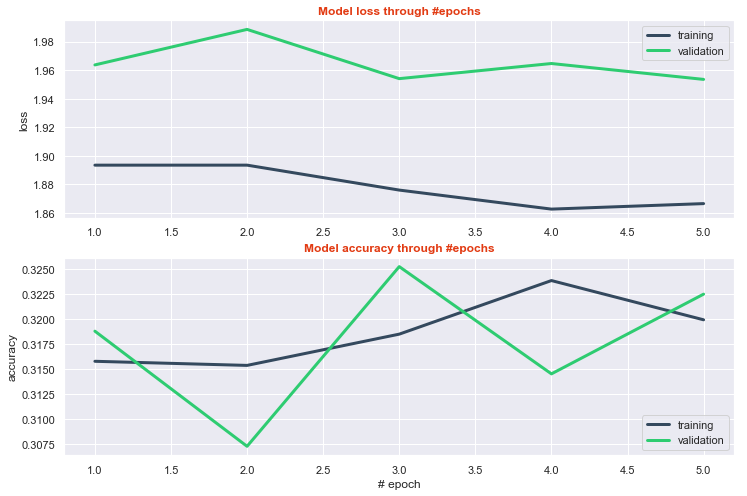

In [31]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## 4. SimpleRNN

In [32]:
train_gen = generate_batch(sents_word, s_word2index, sents_pos,
                           t_word2index, BATCH_SIZE, MAX_SEQLEN)
test_gen = generate_batch(test_sents_word, s_word2index, test_sents_pos,
                          t_word2index, BATCH_SIZE, MAX_SEQLEN)

In [33]:
sents_word, word_frequencies, sents_pos, pos_frequencies = parsed_sentences(train_conll_fname)
test_sents_word, test_word_frequencies, test_sents_pos, test_pos_frequencies = parsed_sentences(test_conll_fname)

In [34]:
hist_acc, hist_val_acc, hist_loss, hist_val_loss = [], [], [], []

In [35]:
for i in range(NUM_ITERATIONS):    
    history = SimpleRNN_POS_TAGGER.fit_generator(train_gen, 
                                  steps_per_epoch=num_train_samples, 
                                  epochs=NUM_EPOCHS,
                                  validation_data=test_gen, 
                                  validation_steps=num_test_samples)
    # save off history data
    hist_acc.extend(history.history["acc"])
    hist_val_acc.extend(history.history["val_acc"])
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])
    
    # Проиллюстрируем некоторые примеры разметки
    
    Xtest, Ytest = next(test_gen)
    Ytest_ = SimpleRNN_POS_TAGGER.predict(Xtest)
    ytest = np.argmax(Ytest, axis=2)
    ytest_ = np.argmax(Ytest_, axis=2)
    
    print("=" * 80)
    print("Iteration # {:d}".format(i + 1))
    print("-" * 80)
    for i in range(min(5, Ytest.shape[0])):
        sent_ids = Xtest[i]
        sent_words = [s_index2word[x] for x in sent_ids.tolist()]
        pos_labels = [t_index2word[x] for x in ytest[i].tolist()]
        pos_preds = [t_index2word[x] for x in ytest_[i].tolist()]
        triples = [x for x in zip(sent_words, pos_labels, pos_preds)
            if x[0] != "PAD"]
        print("label:     " + " ".join([x[0] +"//"+x[1].upper() 
            for x in triples]))
        print("predicted: " + " ".join([x[0] +"//"+x[2].upper() 
            for x in triples]))
        print("-" * 80)

Epoch 1/5
35/35 [==============================] - 7s 191ms/step - loss: 2.3361 - acc: 0.2380 - val_loss: 2.1227 - val_acc: 0.2911
Epoch 2/5
35/35 [==============================] - 3s 93ms/step - loss: 2.1293 - acc: 0.2806 - val_loss: 2.0790 - val_acc: 0.2954
Epoch 3/5
35/35 [==============================] - 3s 82ms/step - loss: 2.0967 - acc: 0.2841 - val_loss: 2.0687 - val_acc: 0.2964
Epoch 4/5
35/35 [==============================] - 3s 85ms/step - loss: 2.0803 - acc: 0.2859 - val_loss: 2.0688 - val_acc: 0.2953
Epoch 5/5
35/35 [==============================] - 3s 85ms/step - loss: 2.0556 - acc: 0.2894 - val_loss: 2.0549 - val_acc: 0.2981
Iteration # 1
--------------------------------------------------------------------------------
label:     A//DET porcentaxe//NOUN de//ADP hospitalizacións//NOUN UNK//VERB por//ADP UNK//NOUN procedentes//ADJ de//ADP fóra//ADV de//ADP Galicia//PROPN con//ADP problemas//NOUN do//_ de//ADP o//DET aparello//NOUN UNK//ADJ foi//AUX de//ADP UNK//NUM ;//PU

35/35 [==============================] - 3s 85ms/step - loss: 1.9562 - acc: 0.3000 - val_loss: 2.0659 - val_acc: 0.2955
Epoch 2/5
35/35 [==============================] - 3s 90ms/step - loss: 1.9376 - acc: 0.3048 - val_loss: 2.0800 - val_acc: 0.2921
Epoch 3/5
35/35 [==============================] - 3s 86ms/step - loss: 1.9089 - acc: 0.3122 - val_loss: 2.0918 - val_acc: 0.2857
Epoch 4/5
35/35 [==============================] - 3s 82ms/step - loss: 1.9129 - acc: 0.3092 - val_loss: 2.0743 - val_acc: 0.2950
Epoch 5/5
35/35 [==============================] - 3s 84ms/step - loss: 1.8996 - acc: 0.3148 - val_loss: 2.0946 - val_acc: 0.2852
Iteration # 3
--------------------------------------------------------------------------------
label:     Consellería//NOUN de//ADP Economía//NOUN e//CCONJ Facenda//NOUN os//DET clientes//NOUN das//_ de//ADP as//DET caixas//NOUN de//ADP aforros//NOUN galegas//ADJ poderán//VERB presentar//VERB as//DET súas//DET queixas//NOUN referidas//VERB ao//_ a//ADP o//DE

35/35 [==============================] - 3s 83ms/step - loss: 1.8186 - acc: 0.3402 - val_loss: 2.1586 - val_acc: 0.2691
Epoch 2/5
35/35 [==============================] - 3s 86ms/step - loss: 1.8143 - acc: 0.3421 - val_loss: 2.1427 - val_acc: 0.2791
Epoch 3/5
35/35 [==============================] - 3s 93ms/step - loss: 1.7924 - acc: 0.3504 - val_loss: 2.1788 - val_acc: 0.2712
Epoch 4/5
35/35 [==============================] - 3s 87ms/step - loss: 1.7798 - acc: 0.3543 - val_loss: 2.1767 - val_acc: 0.2755
Epoch 5/5
35/35 [==============================] - 3s 85ms/step - loss: 1.7443 - acc: 0.3668 - val_loss: 2.1950 - val_acc: 0.2796
Iteration # 5
--------------------------------------------------------------------------------
label:     UNK//NUM UNK//NOUN )//PUNCT e//CCONJ por//ADP último//ADJ ,//PUNCT como//PRON especies//NOUN UNK//ADJ se//PRON atopan//VERB a//DET UNK//NOUN verde//ADJ (//PUNCT UNK//PROPN UNK//VERB )//PUNCT ,//PUNCT a//DET UNK//NOUN UNK//PROPN (//PUNCT UNK//NUM UNK//NOU

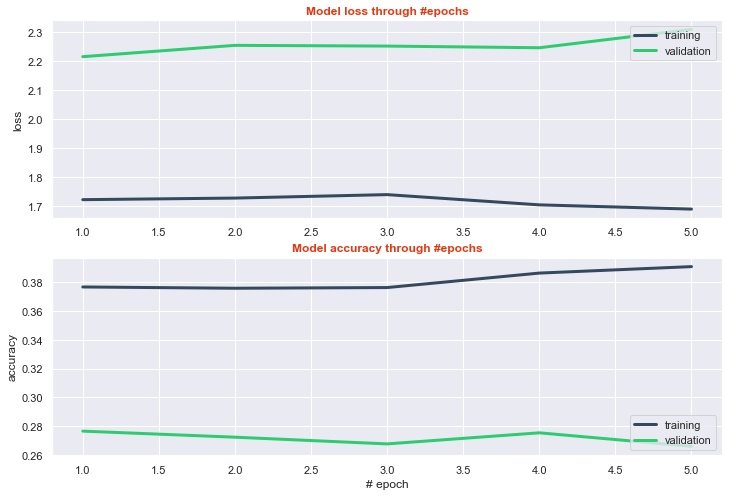

In [36]:
# plot loss and accuracy
plot_model_performance(history.history["loss"], history.history["acc"], history.history["val_loss"], history.history["val_acc"])

## Результаты

Наилучший показатель accuracy показывает Bidirectional LSTM - 0.35, что ожидаемо, т.к. данная архитектура лучше всего использует контекст данных для предсказания.

Наихудший показатель accuracy показывает SimpleRNN - 0.26, т.к. нет механизма для запоминания результатов, и она теряет градиенты.